# Probabilities, Bayesian Inference, and MCMC Demo
Trey V. Wenger, 09 October 2023

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
import pymc as pm # MCMC Sampler
import pytensor.tensor as pt # Math for MCMC
import arviz as az # MCMC data handling and visualization
import corner # Data visualization

In [2]:
# Random state for reproducibility
rng = np.random.RandomState(seed=1234)

# Example 1

## Simulation:
$$
\begin{aligned}
X & \sim \text{Uniform}(-1, 1) \\
Y & \sim MX + B + \text{Normal}(0, S) \\
\end{aligned}
$$

In [3]:
# Generate some synthetic data
X_observed = rng.uniform(-1.0, 1.0, 100)
M_true = 2.0
B_true = -1.0
Y_true = M_true * X_observed + B_true
S_true = 0.5
Y_observed = Y_true + rng.randn(100) * S_true

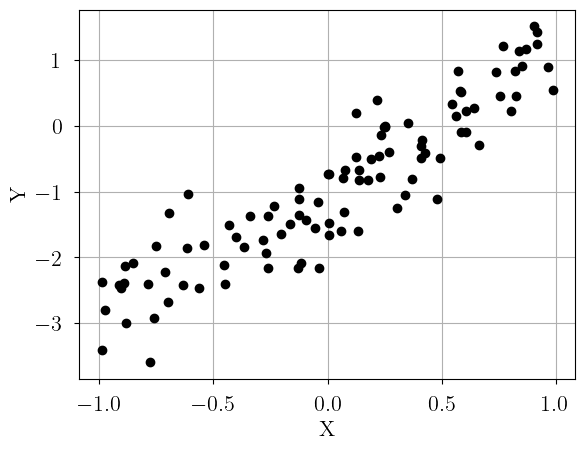

In [4]:
plt.plot(X_observed, Y_observed, 'ko')
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

In [5]:
# The model
def model(X, *params):
    M, B = params
    return M * X + B

# The residuals
def residuals(params, X, Y, sigma):
    Y_predicted = model(X, *params)
    return (Y - Y_predicted) / sigma

In [6]:
# Ordinary Least Squares
x0 = (0.0, 0.0) # guess
result = least_squares(residuals, x0, args=(X_observed, Y_observed, S_true))
M_fit, B_fit = result.x
# covariance matrix estimate
cov = np.linalg.inv(result.jac.T.dot(result.jac))
M_fit_err, B_fit_err = np.sqrt(np.diag(cov))

print(f"M_fit = {M_fit:.2f} +/- {M_fit_err:.2f}")
print(f"B_fit = {B_fit:.2f} +/- {B_fit_err:.2f}")

M_fit = 1.97 +/- 0.09
B_fit = -0.99 +/- 0.05


Gaussian likelihood:
$$
P(Y_{\rm obs} | X_{\rm obs}, M, B, S) = \prod \frac{1}{\sqrt{2\pi S^2}}e^{-\frac{(Y_{\rm model}(X_{\rm obs}, M, B) - Y_{\rm obs})^2}{2S^2}}
$$
$$
\log P(Y_{\rm obs} | X_{\rm obs}, M, B, S) \propto \sum \frac{(Y_{\rm model}(X_{\rm obs}, M, B) - Y_{\rm obs})^2}{S^2} = \sum R^2
$$

Text(0, 0.5, 'B')

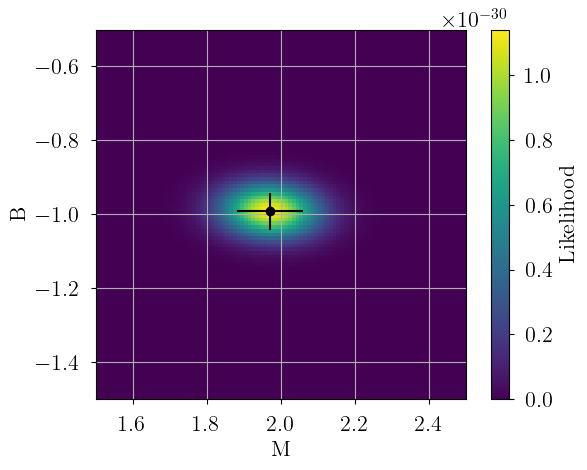

In [7]:
M_grid, B_grid = np.mgrid[1.5:2.5:100j, -1.5:-0.5:100j]
log_likelihood = -0.5 * (model(X_observed[:, None, None], M_grid, B_grid) - Y_observed[:, None, None])**2.0/S_true**2.0 - 0.5*np.log(2.0*np.pi*S_true**2.0)
plt.imshow(np.exp(log_likelihood.sum(axis=0)).T, origin='lower', extent=[M_grid.min(), M_grid.max(), B_grid.min(), B_grid.max()])
plt.errorbar(M_fit, B_fit, xerr=M_fit_err, yerr=B_fit_err, marker='o', color='k')
plt.colorbar(label="Likelihood")
plt.xlabel("M")
plt.ylabel("B")

## Probabilities
$$
\begin{aligned}
P_{A}(a) & \rightarrow \text{Probability of event a over range of possible events A} \\
P_{AB}(a, b) & \rightarrow \text{Joint probability of a and b} \\
P_{AB}(a | b) & \rightarrow \text{Conditional probability of a given b} \\
P_{AB}(a) & \rightarrow \text{Marginal probability of a over all B} \\
\end{aligned}
$$

## Joint probabilities
$$
\begin{aligned}
a \in A & = \{1, 2, 3, 4, 5, 6\} \\
b \in B & = \{1, 2, 3, 4, 5, 6\} \\
P_{AB}(a, b) & = P_{A}(a) P_{B}(b) \\
P_{AB}(2, 3) & = \frac{1}{6}\times\frac{1}{6} = \frac{1}{36} \\
\end{aligned}
$$

## Marginal probabilities
$$
\begin{aligned}
P_{AB}(b) & = \sum_A P_{AB}(a, b) = \int_A P_{AB}(a, b)\,da \\
P_{AB}(6) & = \sum_{a=1}^{6} \frac{1}{36} = \frac{1}{6} \\
\end{aligned}
$$

## Conditional probabilities
$$
\begin{aligned}
P_{AB}(b | a) & = \frac{P_{AB}(a, b)}{P_{AB}(a)} \\
P_{AB}(6 | 2) & = \frac{P_{AB}(6, 2)}{P_{AB}(2)} \\
P_{AB}(6 | 2) & = \frac{1/36}{1/6} = \frac{1}{6}
\end{aligned}
$$

## Bayes' Theorem
$$
\begin{aligned}
P_{AB}(b | a) & = \frac{P_{AB}(a, b)}{P_{AB}(a)} \\
P_{AB}(a | b) & = \frac{P_{AB}(a, b)}{P_{AB}(b)} \\
P_{AB}(b | a) & = \frac{P_{AB}(a | b) \times P_{AB}(b)}{P_{AB}(a)} \\
{\rm Posterior} & = \frac{{\rm Likelihood} \times {\rm Prior}}{\rm Evidence} \\
\end{aligned}
$$

## Applied Bayes' Theorem
$$
\begin{aligned}
P(M, B, S | X_{\rm obs}, Y_{\rm obs}) & = \frac{P(Y_{\rm obs} | X_{\rm obs}, M, B, S) \times P(M, B, S)}{P(Y_{\rm obs})} \\
\end{aligned}
$$

In [8]:
# pymc model
with pm.Model(coords={"data": range(len(X_observed))}) as model:
    # avoid uniform priors if possible! You probably know something!
    # M = pm.Uniform("M", lower=-10.0, upper=10.0)
    # B = pm.Uniform("B", lower=-10.0, upper=10.0)
    # weakly-informative priors (think: "true" value probably within +/- 3 sigma)
    M = pm.Normal("M", mu=0.0, sigma=10.0) # slope
    B = pm.Normal("B", mu=0.0, sigma=10.0) # intercept
    # S = S_true # measurement error
    S = pm.HalfNormal("S", sigma=1.0) # intrinsic scatter
    # model expectation
    Y_mu = pm.Deterministic("Y_mu", M * X_observed + B, dims="data") # track this parameter
    # likelihood
    Y = pm.Normal("Y", mu=Y_mu, sigma=S, observed=Y_observed, dims="data")

In [9]:
# sample prior predictive
with model:
    prior_trace = pm.sample_prior_predictive(1000, random_seed=rng) # 1000 samples

Sampling: [B, M, S, Y]


In [10]:
prior_trace

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

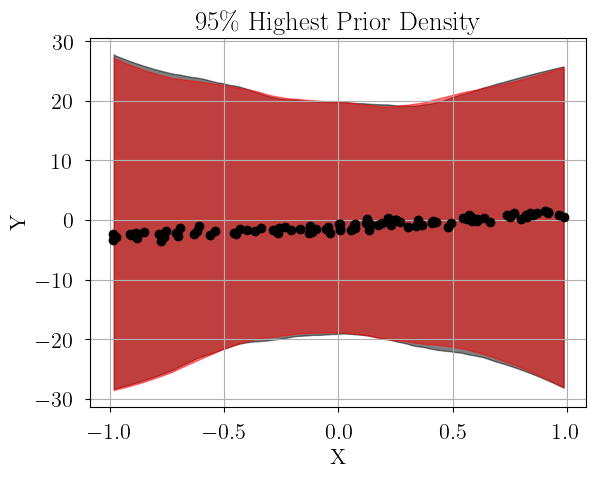

In [11]:
# Plot prior predictive
plt.plot(X_observed, Y_observed, 'ko')
az.plot_hdi(X_observed, prior_trace.prior_predictive.Y, hdi_prob=0.95, color='k')
az.plot_hdi(X_observed, prior_trace.prior.Y_mu, hdi_prob=0.95, color='r')
plt.xlabel("X")
plt.ylabel("Y")
plt.title("95\% Highest Prior Density")
plt.show()

In [12]:
# sample posterior
with model:
    trace = pm.sample(tune=1000, draws=1000, chains=4, discard_tuned_samples=False, random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [M, B, S]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [13]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

Warmup iterations saved (warmup_*).

/tmp/ipykernel_141407/1851211300.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


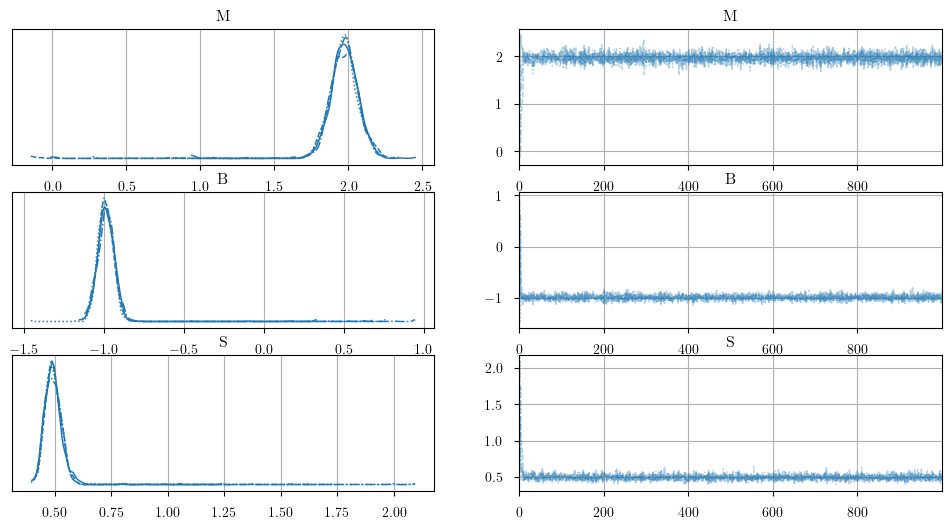

In [14]:
axes = az.plot_trace(trace.warmup_posterior, var_names=["M", "B", "S"])
fig = axes.ravel()[0].figure
fig.show()

/tmp/ipykernel_141407/3459719749.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


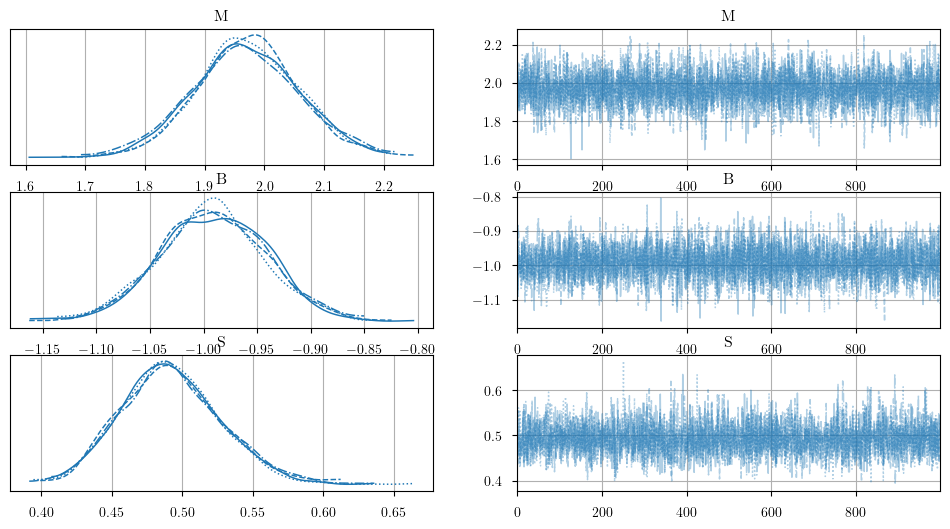

In [15]:
axes = az.plot_trace(trace.posterior, var_names=["M", "B", "S"])
fig = axes.ravel()[0].figure
fig.show()

In [16]:
az.summary(trace)
# r_hat = 1 -> all chains appear converged to same distribution
# ess = effective sample size (number of independent samples)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
M,1.970,0.089,1.814,2.156,0.001,0.001,6402.0,3143.0,1.0
B,-0.991,0.049,-1.085,-0.898,0.001,0.000,6192.0,3104.0,1.0
S,0.492,0.036,0.429,0.559,0.000,0.000,5124.0,3008.0,1.0
Y_mu[0],-2.207,0.076,-2.345,-2.060,0.001,0.001,6479.0,3147.0,1.0
Y_mu[1],-0.510,0.053,-0.606,-0.407,0.001,0.000,6380.0,2984.0,1.0
...,...,...,...,...,...,...,...,...,...
Y_mu[95],-0.981,0.049,-1.075,-0.889,0.001,0.000,6188.0,3136.0,1.0
Y_mu[96],-0.846,0.049,-0.932,-0.745,0.001,0.000,6205.0,3005.0,1.0
Y_mu[97],0.266,0.074,0.125,0.405,0.001,0.001,6727.0,3161.0,1.0
Y_mu[98],-2.736,0.095,-2.919,-2.557,0.001,0.001,6576.0,3079.0,1.0


In [17]:
# sample posterior predictive
with model:
    posterior_trace = pm.sample_posterior_predictive(trace)

Sampling: [Y]


In [18]:
posterior_trace

Inference data with groups:
	> posterior_predictive
	> observed_data

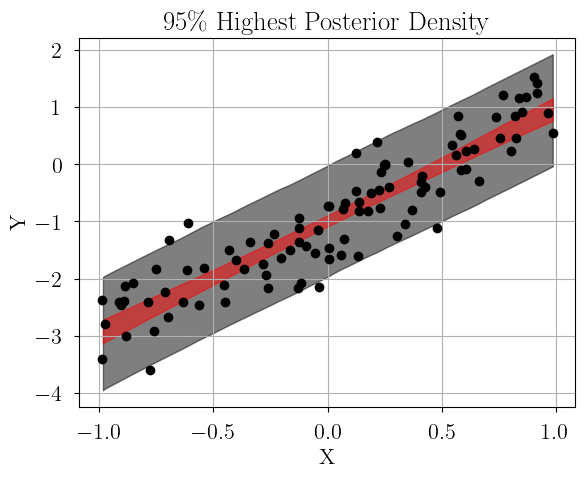

In [19]:
# Posterior predictive
plt.plot(X_observed, Y_observed, 'ko')
az.plot_hdi(X_observed, posterior_trace.posterior_predictive.Y, hdi_prob=0.95, color='k')
az.plot_hdi(X_observed, trace.posterior.Y_mu, hdi_prob=0.95, color='r')
plt.xlabel("X")
plt.ylabel("Y")
plt.title("95\% Highest Posterior Density")
plt.show()

/tmp/ipykernel_141407/2684043057.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


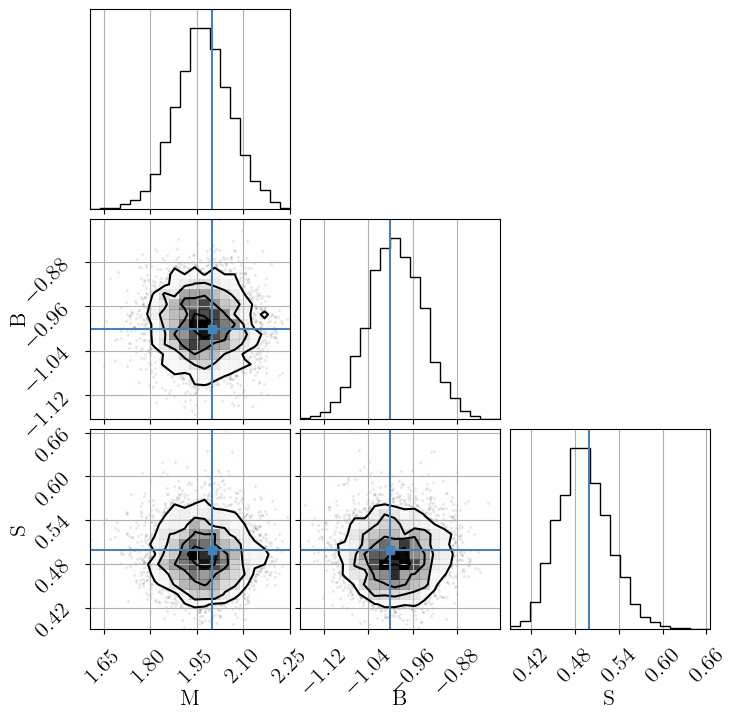

In [20]:
fig = corner.corner(trace, truths=[M_true, B_true, S_true], var_names=["M", "B", "S"])
fig.show()

# Example 2

## Simulation:
$$
\begin{aligned}
X & \sim \text{Uniform}(-1, 1) \\
Y & \sim MX + B + \text{Normal}(0, S) \\
A & = \text{arctan2}(Y, X) + \text{Normal}(0, E) \\
\end{aligned}
$$

In [21]:
A_true = np.arctan2(Y_observed, X_observed)
E_true = np.deg2rad(1.0)
A_observed = A_true + rng.randn(100) * E_true
# wrap to +/- pi
A_observed = (A_observed + np.pi) % (2.0 * np.pi) - np.pi

Text(0, 0.5, 'Number')

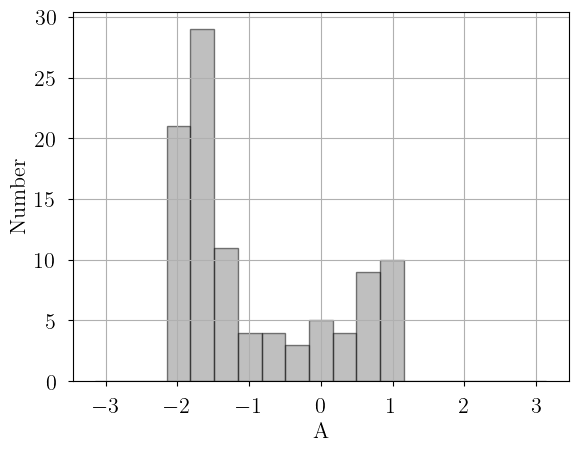

In [22]:
bins = np.linspace(-np.pi, np.pi, 20)
plt.hist(A_observed, bins=bins, color='gray', edgecolor='k', alpha=0.5)
plt.xlabel("A")
plt.ylabel("Number")

Text(0, 0.5, 'Y')

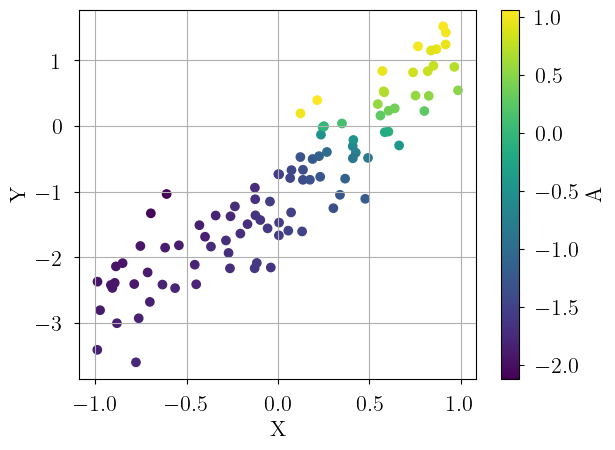

In [23]:
plt.scatter(X_observed, Y_observed, c=A_observed, marker='o')
plt.colorbar(label="A")
plt.xlabel("X")
plt.ylabel("Y")

In [24]:
with pm.Model(coords={'data': range(len(A_observed))}) as model:
    # prior
    M = pm.HalfNormal("M", sigma=3.0)
    abs_B = pm.HalfNormal("abs_B", sigma=3.0)
    B = pm.Deterministic("B", -1.0 * abs_B) # B is negative, track this parameter
    S = pm.HalfNormal("S", sigma=1.0)
    # unobserved
    X = pm.Uniform("X", lower=-1.0, upper=1.0, dims='data')
    # model expectation
    Y_mu = pm.Deterministic("Y_mu", M*X + B, dims="data") # track this parameter
    Y = pm.Normal("Y", mu=Y_mu, sigma=S, dims='data')
    A_mu = pt.arctan2(Y, X)
    # likelihood
    A = pm.TruncatedNormal(
        "A", mu=A_mu, sigma=E_true, lower=-np.pi, upper=np.pi,
        transform=pm.distributions.transforms.circular, observed=A_observed)

In [25]:
# sample prior predictive
with model:
    prior_trace = pm.sample_prior_predictive(1000, random_seed=rng)

Sampling: [A, M, S, X, Y, abs_B]


In [26]:
prior_trace

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

Text(0, 0.5, 'Number')

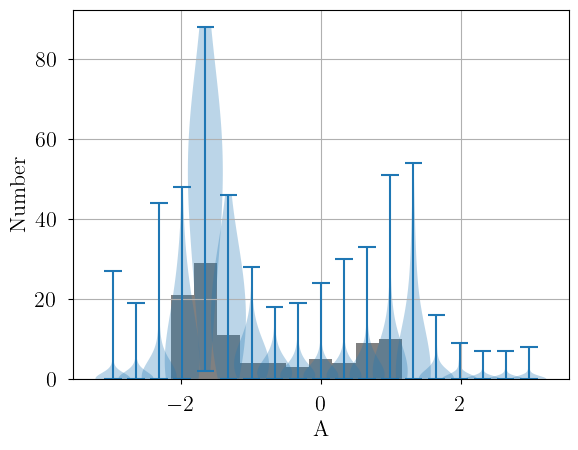

In [27]:
# bin prior predictive samples
prior_binned_A = np.array(
    [np.histogram(prior_trace.prior_predictive.A.sel(chain=chain, draw=draw), bins=bins)[0]
     for chain in prior_trace.prior_predictive.chain for draw in prior_trace.prior_predictive.draw])

# Plot prior predictive
plt.hist(A_observed, bins=bins, color='gray')
bin_centers = bins[:-1] + (bins[1] - bins[0])/2.0
plt.violinplot(prior_binned_A, bin_centers, bw_method=1.0)
plt.xlabel("A")
plt.ylabel("Number")

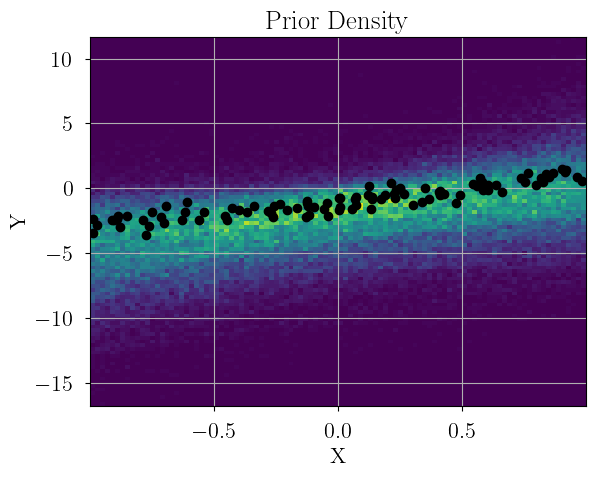

In [37]:
# Prior
plt.hist2d(prior_trace.prior.X.data.flatten(), prior_trace.prior.Y.data.flatten(), bins=100)
plt.plot(X_observed, Y_observed, 'ko')
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Prior Density")
plt.show()

In [28]:
# sample posterior
with model:
    trace = pm.sample(tune=1000, draws=1000, chains=4, random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [M, abs_B, S, X, Y]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 278 seconds.
There were 483 divergences after tuning. Increase `target_accept` or reparameterize.


In [29]:
az.summary(trace, var_names=["M", "B", "S", "X"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
M,1.926,0.132,1.665,2.162,0.003,0.002,1570.0,2334.0,1.0
B,-1.044,0.110,-1.258,-0.847,0.005,0.004,440.0,745.0,1.0
S,0.578,0.090,0.414,0.745,0.004,0.003,409.0,683.0,1.0
X[0],-0.714,0.204,-1.000,-0.345,0.005,0.004,1587.0,1812.0,1.0
X[1],0.611,0.203,0.273,0.997,0.005,0.004,1561.0,1528.0,1.0
...,...,...,...,...,...,...,...,...,...
X[95],-0.023,0.029,-0.077,0.026,0.001,0.001,2068.0,1121.0,1.0
X[96],0.133,0.055,0.030,0.230,0.001,0.001,1895.0,1801.0,1.0
X[97],0.678,0.208,0.318,1.000,0.005,0.004,1316.0,1200.0,1.0
X[98],-0.726,0.209,-1.000,-0.333,0.005,0.003,1720.0,1873.0,1.0


In [30]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [31]:
# sample posterior predictive
with model:
    posterior_trace = pm.sample_posterior_predictive(trace)

Sampling: [A]


In [32]:
posterior_trace

Inference data with groups:
	> posterior_predictive
	> observed_data

Text(0, 0.5, 'Number')

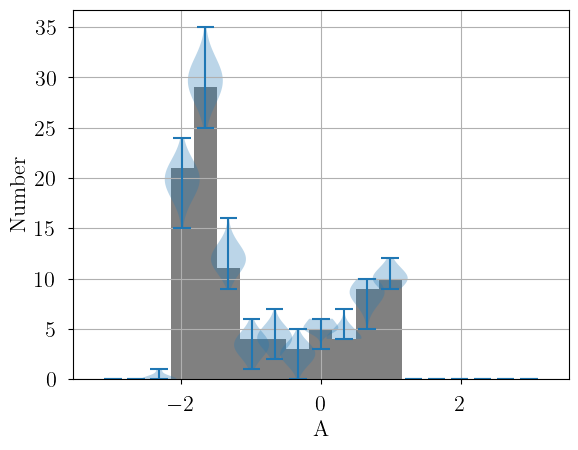

In [33]:
# bin posterior predictive samples
posterior_binned_A = np.array(
    [np.histogram(posterior_trace.posterior_predictive.A.sel(chain=chain, draw=draw), bins=bins)[0]
     for chain in posterior_trace.posterior_predictive.chain for draw in posterior_trace.posterior_predictive.draw])

# Plot posterior predictive
plt.hist(A_observed, bins=bins, color='gray')
bin_centers = bins[:-1] + (bins[1] - bins[0])/2.0
plt.violinplot(posterior_binned_A, bin_centers, bw_method=1.0)
plt.xlabel("A")
plt.ylabel("Number")

/tmp/ipykernel_141407/2684043057.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


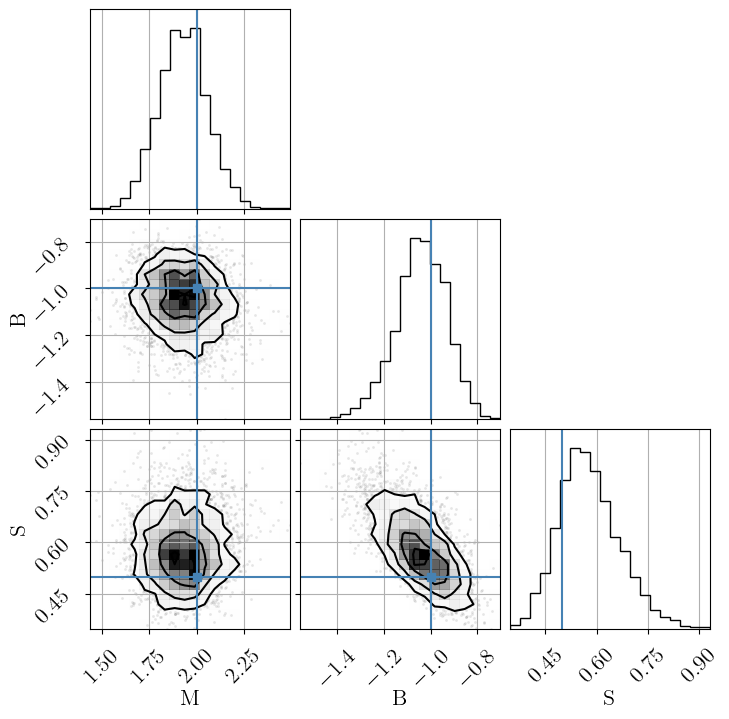

In [34]:
fig = corner.corner(trace, truths=[M_true, B_true, S_true], var_names=["M", "B", "S"])
fig.show()

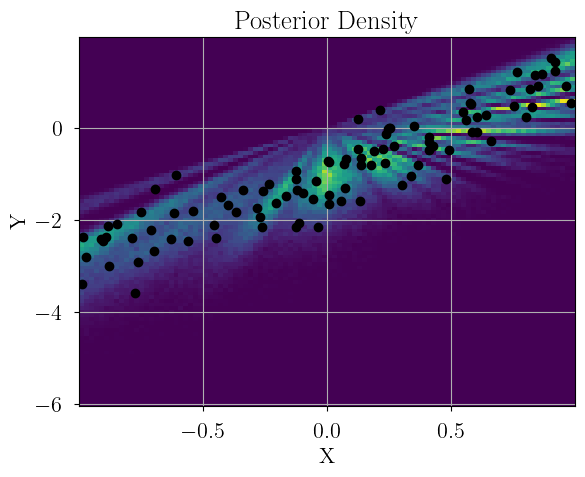

In [39]:
# Posterior
plt.hist2d(trace.posterior.X.data.flatten(), trace.posterior.Y.data.flatten(), bins=100)
plt.plot(X_observed, Y_observed, 'ko')
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Posterior Density")
plt.show()